In [31]:
pip install adjustText

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

In [2]:
data1 = pd.read_csv("datasets\imputed_data_QS_RF.csv")
data2 = pd.read_csv("datasets\imputed_data_QS_XGB.csv")
data2_sub = data2[['Institution Name', 'Year', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE']]
# 进行合并
merged_df = pd.merge(data1, data2_sub, on=['Institution Name', 'Year'], how='left')
# 计算平均值并创建新列
merged_df['IRN_SCORE'] = (merged_df['IRN_SCORE_x'] + merged_df['IRN_SCORE_y']) / 2
merged_df['EO_SCORE']  = (merged_df['EO_SCORE_x']  + merged_df['EO_SCORE_y'])  / 2
merged_df['S_SCORE']   = (merged_df['S_SCORE_x']   + merged_df['S_SCORE_y'])   / 2
merged_df.drop(columns=['IRN_SCORE_x', 'IRN_SCORE_y',
                        'EO_SCORE_x',  'EO_SCORE_y',
                        'S_SCORE_x',   'S_SCORE_y'], inplace=True)
data = merged_df
numeric_data = data.drop(columns=['Rank', 'Institution Name', 'Country', 'Year','CS','CF','RI','Age','STA','Overall'])
numeric_data_standardized = (numeric_data - numeric_data.mean()) / numeric_data.std()

In [3]:
numeric_data_standardized.head()

,AR_SCORE,ER_SCORE,FS_SCORE,CPF_SCORE,IF_SCORE,IS_SCORE,IRN_SCORE,EO_SCORE,S_SCORE
0,3.024884,2.870956,2.260853,2.414919,1.888664,2.069494,1.280016,3.012929,1.862330
1,3.024884,2.870956,2.260853,2.397577,1.877068,1.321199,1.640523,3.069899,1.965150
2,3.024884,2.870956,2.201675,2.414919,1.787199,1.401145,1.632038,3.066247,1.978737
3,3.004376,2.299217,2.260853,2.418388,1.697330,1.848843,0.521766,1.389109,1.120990
4,3.024884,2.870956,2.260853,1.665719,1.813290,2.120659,1.677074,3.066556,1.705223


### Implementing PCA

In [4]:
pca = PCA()
pca.fit(numeric_data_standardized)

explained_variance_ratio = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

for i, var in enumerate(explained_variance_ratio, start=1):
    print(f"PC{i}: {var * 100:.2f}% variance explained")

PC1: 54.34% variance explained
PC2: 12.89% variance explained
PC3: 10.78% variance explained
PC4: 7.14% variance explained
PC5: 5.50% variance explained
PC6: 3.47% variance explained
PC7: 2.50% variance explained
PC8: 2.07% variance explained
PC9: 1.31% variance explained


In [5]:
cumulative_variance = np.cumsum(explained_variance_ratio)*100
cumulative_variance

array([ 54.33973379,  67.2252829 ,  78.00327022,  85.14391566,
        90.64530125,  94.11616018,  96.61924669,  98.68955179,
       100.        ])

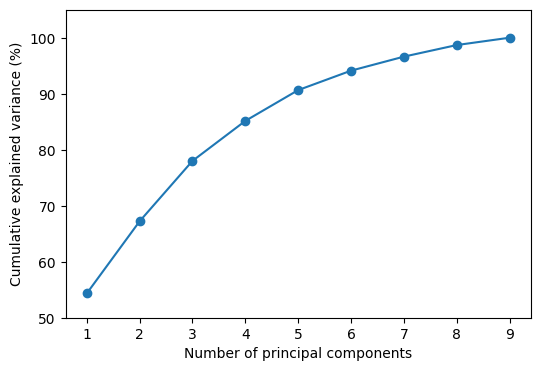

In [6]:
plt.figure(figsize=(6, 4))

plt.scatter(range(1,numeric_data_standardized.shape[1]+1),cumulative_variance)
plt.plot(range(1,numeric_data_standardized.shape[1]+1),cumulative_variance)
plt.xlabel('Number of principal components',fontsize=10)
plt.ylabel('Cumulative explained variance (%)',fontsize=10)
plt.ylim(50, 105)
plt.show()

### Factor Analysis

In [7]:
# KMO Test
scaler = StandardScaler()
df_scaled = scaler.fit_transform(numeric_data)

kmo_all,kmo_model=calculate_kmo(df_scaled)
kmo_model

0.8586770162519326

In [8]:
# Bartlett’s Test of Sphericity
chi2_val, p_val = calculate_bartlett_sphericity(numeric_data)

print(f"Bartlett's test of result:")
print(f"statistic = {chi2_val:.4f}")
print(p_val,"p-value")

Bartlett's test of result:
statistic = 59415.0520
0.0 p-value


In [9]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer()
fa.fit(numeric_data_standardized)
eigen_values, vectors = fa.get_eigenvalues()
eigen_values

array([4.89057604, 1.15969942, 0.97001886, 0.64265809, 0.4951247 ,
       0.3123773 , 0.22527779, 0.18632746, 0.11794034])

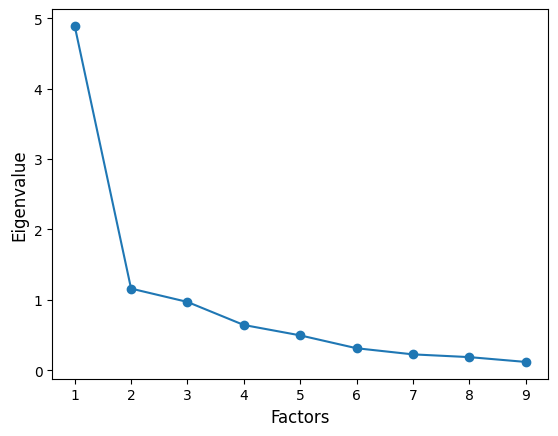

In [10]:
plt.scatter(range(1,df_scaled.shape[1]+1),eigen_values)
plt.plot(range(1,df_scaled.shape[1]+1),eigen_values)
plt.xlabel('Factors',fontsize=12)
plt.ylabel('Eigenvalue',fontsize=12)
plt.show()

In [11]:
fa = FactorAnalyzer(n_factors=4, rotation='varimax', method='principal')
fa.fit(numeric_data_standardized)

fa1 = FactorAnalyzer(n_factors=4, rotation=None, method='principal')
fa1.fit(numeric_data_standardized)

loadings = pd.DataFrame(
    fa.loadings_,
    index = numeric_data_standardized.columns,
    columns=['Factor1', 'Factor2','Factor3','Factor4']
)
loadings1 = pd.DataFrame(
    fa1.loadings_,
    index = numeric_data_standardized.columns,
    columns=['Factor1', 'Factor2','Factor3','Factor4']
)
print("Loading matrix：\n", loadings)

Loading matrix：
             Factor1   Factor2   Factor3   Factor4
AR_SCORE   0.823841  0.157635  0.156597  0.415806
ER_SCORE   0.893390  0.183338  0.117827  0.184500
FS_SCORE   0.196232  0.090562  0.974898  0.041319
CPF_SCORE  0.160290  0.218821 -0.000472  0.814504
IF_SCORE   0.165896  0.858556  0.033874  0.271381
IS_SCORE   0.197616  0.882242  0.095870  0.161742
IRN_SCORE  0.375574  0.171141  0.052040  0.795846
EO_SCORE   0.855919  0.171598  0.121252  0.260772
S_SCORE    0.527499  0.271517  0.096258  0.664722


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


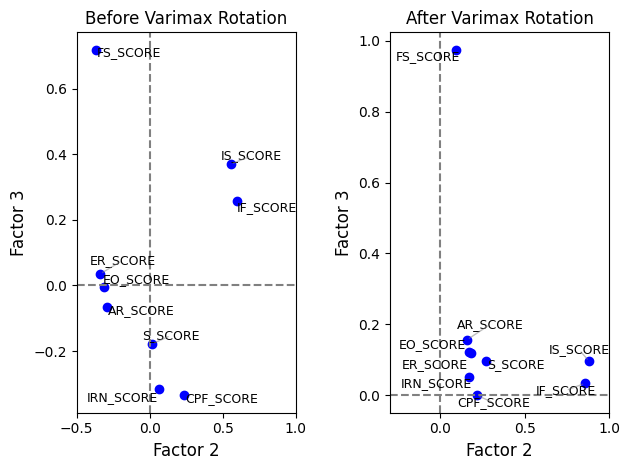

In [12]:
# Plot the difference of using rotation
plt.subplot(1, 2, 1)
plt.scatter(fa1.loadings_[:, 1], fa1.loadings_[:, 2], c='blue')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Before Varimax Rotation")
plt.xlabel("Factor 2",fontsize=12)
plt.ylabel("Factor 3",fontsize=12)
plt.xlim(-0.5, 1)
texts = []
for i, txt in enumerate(loadings.index):
    texts.append(plt.text(loadings1.iloc[i, 1], loadings1.iloc[i, 2], txt, ha='center',va='center',fontsize=9))
adjust_text(
    texts, 
    x=fa1.loadings_[:, 1], 
    y=fa1.loadings_[:, 2],
    arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5),  
    force_points=0.2,  
    force_text=0.2, 
    expand_points=(1.2, 1.2),  
    expand_text=(1.2, 1.2),
    lim=500
)

plt.subplot(1, 2, 2)
plt.scatter(fa.loadings_[:, 1], fa.loadings_[:, 2], c='blue')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("After Varimax Rotation")
plt.xlabel("Factor 2",fontsize=12)
plt.ylabel("Factor 3",fontsize=12)
plt.xlim(-0.3, 1)

texts = []
for i, txt in enumerate(loadings.index):
    texts.append(plt.text(loadings.iloc[i, 1], loadings.iloc[i, 2], txt, ha='center',va='center',fontsize=9))

adjust_text(
    texts, 
    x=fa.loadings_[:, 1], 
    y=fa.loadings_[:, 2],
    arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5),  
    force_points=0.2,  
    force_text=0.2, 
    expand_points=(1.2, 1.2),  
    expand_text=(1.2, 1.2),
    lim=500
)
plt.tight_layout(w_pad=2.0, h_pad=2.0)
plt.show()

Factor 1: 1,2,8  AR_SCORE, ER_SCORE, EO_SCORE

Factor 2: 5,6  IF_SCORE, IS_SCORE

Factor 3: 3  FS_SCORE

Factor 4: 4,7,9  CPF_SCORE, IRN_SCORE , S_SCORE

In [13]:
cum_explained_variance_ratio = fa.get_factor_variance()
for i, var in enumerate(cum_explained_variance_ratio[2], start=1):
    print(f"Factor{i}: {var * 100:.2f}% culmulative variance explained")

Factor1: 30.66% culmulative variance explained
Factor2: 50.24% culmulative variance explained
Factor3: 61.64% culmulative variance explained
Factor4: 85.14% culmulative variance explained


In [14]:
fa.get_communalities()

array([0.90097963, 0.87968126, 0.99884111, 0.73699334, 0.83943394,
       0.85275484, 0.80642402, 0.84474659, 0.80309766])

### Calculate FA_Score

In [15]:
FA_Score = fa.fit_transform(numeric_data_standardized)
FA_Score = pd.DataFrame(FA_Score, columns=['FA_1', 'FA_2','FA_3','FA_4'])
FA_Score_standardized = (FA_Score - FA_Score.min()) / (FA_Score.max() - FA_Score.min())
FA_Score_standardized.head()

,FA_1,FA_2,FA_3,FA_4
0,0.757755,0.660698,0.761455,0.658492
1,0.761897,0.549166,0.764023,0.718516
2,0.763375,0.549125,0.750595,0.718740
3,0.616795,0.652353,0.812048,0.638057
4,0.786222,0.660116,0.759762,0.602440


### Calculate PCA_Score

In [16]:
col_factor1 = ['AR_SCORE', 'ER_SCORE', 'EO_SCORE']
col_factor2 = ['IF_SCORE', 'IS_SCORE']
col_factor3 = ['FS_SCORE']
col_factor4 = ['CPF_SCORE', 'IRN_SCORE', 'S_SCORE']
factor1 = numeric_data_standardized[col_factor1]
factor2 = numeric_data_standardized[col_factor2]
factor3 = numeric_data_standardized[col_factor3]
factor4 = numeric_data_standardized[col_factor4]

In [17]:
# PCA for each factor
factor_num = loadings.shape[1]
explained_variance_ratio = np.zeros(factor_num)

pca = PCA(n_components = 1)
pca_scores1 = pca.fit_transform(factor1)
explained_variance_ratio[0] = pca.explained_variance_ratio_[0]
pca_scores2 = pca.fit_transform(factor2)
explained_variance_ratio[1] = pca.explained_variance_ratio_[0]
pca_scores3 = pca.fit_transform(factor3)
explained_variance_ratio[2] = pca.explained_variance_ratio_[0]
pca_scores4 = pca.fit_transform(factor4)
explained_variance_ratio[3] = pca.explained_variance_ratio_[0]

In [18]:
for i, var in enumerate(explained_variance_ratio, start=1):
    print(f"Factor {i}: {var * 100:.2f}% variance explained")

Factor 1: 87.21% variance explained
Factor 2: 84.25% variance explained
Factor 3: 100.00% variance explained
Factor 4: 75.89% variance explained


In [19]:
PCA_Score = np.column_stack((pca_scores1, pca_scores2, pca_scores3, pca_scores4))
PCA_Score = pd.DataFrame(PCA_Score, columns=['pca_1', 'pca_2','pca_3','pca_4'])
PCA_Score_standardized = (PCA_Score - PCA_Score.min()) / (PCA_Score.max() - PCA_Score.min())
PCA_Score_standardized.head()

,pca_1,pca_2,pca_3,pca_4
0,0.991879,0.979328,1.000000,0.928445
1,0.996533,0.853371,1.000000,0.974030
2,0.996235,0.851726,0.982811,0.976073
3,0.809984,0.911039,1.000000,0.776481
4,0.996260,0.975315,1.000000,0.886831


In [20]:
model_score = pd.concat([data[['Institution Name','Country','Year']],FA_Score_standardized, PCA_Score_standardized],axis = 1)
model_score.to_csv('datasets\model_score.csv',index = False)
model_score.head()

,Institution Name,Country,Year,FA_1,FA_2,FA_3,FA_4,pca_1,pca_2,pca_3,pca_4
0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),United States,2018,0.757755,0.660698,0.761455,0.658492,0.991879,0.979328,1.000000,0.928445
1,STANFORD UNIVERSITY,United States,2018,0.761897,0.549166,0.764023,0.718516,0.996533,0.853371,1.000000,0.974030
2,HARVARD UNIVERSITY,United States,2018,0.763375,0.549125,0.750595,0.718740,0.996235,0.851726,0.982811,0.976073
3,CALIFORNIA INSTITUTE OF TECHNOLOGY (CALTECH),United States,2018,0.616795,0.652353,0.812048,0.638057,0.809984,0.911039,1.000000,0.776481
4,UNIVERSITY OF CAMBRIDGE,United Kingdom,2018,0.786222,0.660116,0.759762,0.602440,0.996260,0.975315,1.000000,0.886831
